In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging

In [29]:
import numpy as np
from sklearn.decomposition import PCA

from yass.config import Config
from yass.preprocessing import Preprocessor
from yass.neuralnet import NeuralNetDetector
from yass.mainprocess import Mainprocessor
from yass.deconvolute import Deconvolution

logging.basicConfig(level=logging.INFO)

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

Running pipeline with triage NN

In [6]:
cfg = Config.from_yaml('../ej49_config.yaml')

In [9]:
pp = Preprocessor(cfg)
score, clr_idx, spt = pp.process()

/home/eduardo/miniconda3/envs/noise/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: class Preprocessor is deprecated: (Use function in preprocess module, see examples/preprocess.py)
  """Entry point for launching an IPython kernel.
INFO:yass.preprocessing:Preprocessing the data in progress...
/home/eduardo/miniconda3/envs/noise/lib/python3.6/site-packages/progressbar/bar.py:223: DeprecationWarning: The usage of `maxval` is deprecated, please use `max_value` instead
  '`max_value` instead', DeprecationWarning)
N/A% (0 of 1) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--INFO:yass.preprocessing:Preprocessing done in 305 seconds.
INFO:yass.preprocessing:	reading data:	0.92618 seconds
INFO:yass.preprocessing:	filtering:	12.895127 seconds
INFO:yass.preprocessing:	standardization:	3.066574 seconds
INFO:yass.preprocessing:	detection:	252.183204 seconds
INFO:yass.preprocessing:	whitening:	8.218872 seconds
INFO:yass.preprocessing:	saving recording:	2.3

In [78]:
# all spikes in channel 0
spt[0].shape

(26589, 2)

In [79]:
# indexes for clear spikes in channel 0
clr_idx[0].shape

(2011,)

In [38]:
# scores for clear spikes in channel 0
score[0].shape

(2011, 3, 7)

In [611]:
score.shape

(2884, 21)

In [11]:
mp = Mainprocessor(cfg,score,clr_idx,spt)
spikeTrain_clear, spt_left = mp.mainProcess()

/home/eduardo/miniconda3/envs/noise/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: class Mainprocessor is deprecated: (Use function in process module, see examples/process.py)
  """Entry point for launching an IPython kernel.
INFO:yass.mainprocess:Triaging...
INFO:yass.mainprocess:Coresettting...
INFO:yass.mainprocess:Masking...
INFO:yass.mainprocess:Clustering...
/home/eduardo/miniconda3/envs/noise/lib/python3.6/site-packages/progressbar/bar.py:223: DeprecationWarning: The usage of `maxval` is deprecated, please use `max_value` instead
  '`max_value` instead', DeprecationWarning)
100% (8 of 8) |###########################| Elapsed Time: 0:00:15 Time: 0:00:15
INFO:yass.mainprocess:Getting Templates...
100% (1 of 1) |###########################| Elapsed Time: 0:00:01 Time: 0:00:01
INFO:yass.mainprocess:Mainprocess done in 39 seconds.
INFO:yass.mainprocess:	triage:	0.813912 seconds
INFO:yass.mainprocess:	coreset:	7.2079 seconds
INFO:yass.mainprocess:	masking:	0.

In [82]:
# clear spikes assigned to group 0
spikeTrain_clear[spikeTrain_clear[:, 1] == 0].shape

(2884, 2)

In [84]:
# template corresponding to group 0
mp.templates[:, :, 0].shape

(49, 31)

In [12]:
mp.templates.shape

(49, 31, 111)

In [13]:
from yass.MFM import spikesort

Get recording

In [14]:
from yass.preprocess.filter import butterworth
pp.openFile()
rec = pp.load(0,pp.config.batch_size)
rec = butterworth(rec, pp.config.filterLow,
                          pp.config.filterHighFactor,
                          pp.config.filterOrder,
                          pp.config.srate)
small_t = np.min((int(pp.config.srate*5), rec.shape[0]))
mid_T = int(np.ceil(rec.shape[0]/2))
rec_temp = rec[np.arange(mid_T-small_t, mid_T+small_t)]
sd = np.median(np.abs(rec), 0)/0.6745
rec = np.divide(rec,sd)

In [15]:
rec.shape

(6000000, 49)

In [16]:
nnd = NeuralNetDetector(cfg)
proj = nnd.load_w_ae()

In [17]:
proj.shape

(31, 3)

In [18]:
mp.templates.shape

(49, 31, 111)

In [19]:
def templates_in_feature_space(templates,proj):
    R, nfeat = proj.shape
    nchannel, R, n_templates = templates.shape
    
    return np.transpose(np.reshape(
        np.matmul(np.reshape(np.transpose(templates,[0,2,1]),(-1,R)),proj),
        (nchannel, n_templates, nfeat)),(0,2,1))

In [46]:
templates_in_feature_space(mp.templates[:,:,:2], proj).shape

(49, 3, 2)

In [20]:
def close_templates(templates, cluster_id, ncloseK):
    nchan, R, nK = templates.shape
    close_to_far_idx = np.argsort(np.sum(np.square(templates - templates[:,:,[cluster_id]]),axis=(0,1)))
    return close_to_far_idx[:ncloseK]

In [97]:
# find templates close to template 0
close_to_id_1 = close_templates(templates, cluster_id=10, ncloseK=5)
close_to_id_1

array([ 10,  12,  14, 107,  79])

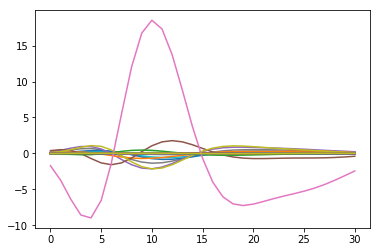

In [98]:
plt.plot(mp.templates[:,:,10].T)
plt.show()

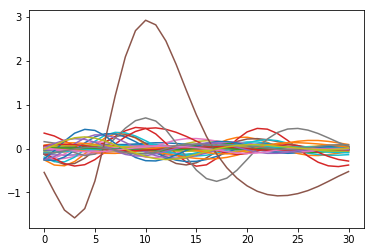

In [107]:
plt.plot(mp.templates[:,:,107].T)
plt.show()

In [67]:
mp.templates[:,:,33].shape

(49, 31)

In [61]:
np.max(mp.templates[:,:,33], axis=1)

array([ 0.15409091,  0.18276515,  0.08931818,  0.08424243,  0.11988636,
        1.1560606 ,  0.31776515,  0.1982197 ,  0.115     ,  0.79875   ,
        0.19026515,  0.08356061,  0.25329545,  4.25640153,  0.10261364,
        0.14087121,  0.21166667,  2.79935607,  0.62912879,  0.11772727,
        0.53662879,  0.04909091,  0.09329545,  0.18439394,  0.85503788,
        0.1067803 ,  0.08075757,  0.32272727,  0.21833334,  0.22386363,
        0.11867424,  0.31893939,  0.21060606,  0.13969697,  0.1167803 ,
        0.7617803 ,  0.16613636,  0.19159092,  0.3610606 ,  0.68515151,
        0.13685606,  0.10231061,  0.55386364,  0.16647727,  0.07344697,
        0.08958334,  0.52098485,  0.22204545,  0.14518939])

In [23]:
np.argmax(np.max(mp.templates[:,:,33], axis=1))

13

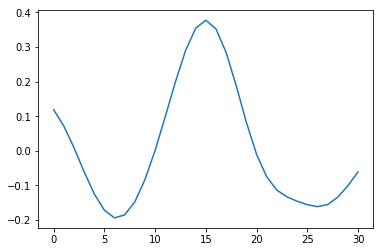

In [71]:
plt.plot(mp.templates[13,:,13].T)
plt.show()

In [255]:
spt_clean = spikeTrain_clear[:,0]
id_clean = spikeTrain_clear[:,1]
templates = mp.templates
cluster_id = 2
n_cluster_plot = 5
neighbor = cfg.neighChannels
plot_length = 15
plot_width = 10
cols = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
plot_name1 = 'waveform.pdf'
plot_name2 = 'scatter_score.pdf'
plot_wf = True
plot_score = 1

In [124]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [144]:
# get parameters
R, nfeat = proj.shape
spike_size = int((R-1)/2)
nchannel, R, n_templates = templates.shape

# dimension reduction of templates
templates_in_feature = templates_in_feature_space(templates,proj)

# find similar templates to template in cluster_id, this will give us overlapping
# clusters
k_idx = close_templates(templates_in_feature, cluster_id, n_cluster_plot)

((49, 31), 9, array([ 1,  5,  9, 12, 17, 20, 24]))

In [429]:
def find_reduced_template(cluster_id):
    """
    Returns reduced template (31 x 7) for a given group
    """
    # find the template for cluster_id
    t_interest = templates[:,:,cluster_id]

    # find the main channel for that template
    c_main = np.argmax(np.max(t_interest,axis=1))

    # find neighbors for that channel - n neighbors vary accross channels
    ch_idx = np.where(neighbor[c_main])[0]
        
    return templates[ch_idx, :, cluster_id]

In [433]:
def find_reduced_similar_templates(cluster_id, k_similar):
    template_ids = close_templates(templates_in_feature, cluster_id, k_similar)
    reduced_templates = np.vstack([find_reduced_template(cid) for cid in template_ids])
    return reduced_templates, np.array(template_ids)

In [434]:
find_reduced_template(6).shape

(5, 31)

In [441]:
reduced, template_ids = find_reduced_similar_templates(cluster_id=2, k_similar=5)
reduced.shape

(35, 31)

In [446]:
templates_in_feature.shape

(49, 3, 111)

In [449]:
ch_idx

array([ 1,  5,  9, 12, 17, 20, 24])

In [448]:
templates_in_feature[ch_idx].shape

(7, 3, 111)

In [443]:
templates_in_feature[ch_idx][:,:,k_idx].shape

(7, 3, 5)

In [ ]:
        print('templates...', ch_idx)
        print(templates_in_feature[ch_idx][:,:,k_idx].shape)
        tt = np.transpose(templates_in_feature[ch_idx][:,:,k_idx],(2,1,0))
        print(tt.shape)
        tt = np.reshape(tt,[tt.shape[0],-1])
        print(tt.shape)

        pca = PCA(n_components=2)
        pca.fit(tt)

In [413]:
find_reduced_template(1).shape

(5, 31)

In [247]:
templates_in_feature.shape

(49, 3, 111)

In [259]:
templates_in_feature[(0,1,2,3),:,:].shape

(4, 3, 111)

In [415]:
templates_in_feature.shape

(49, 3, 111)

In [645]:
rec.shape

(6000000, 49)

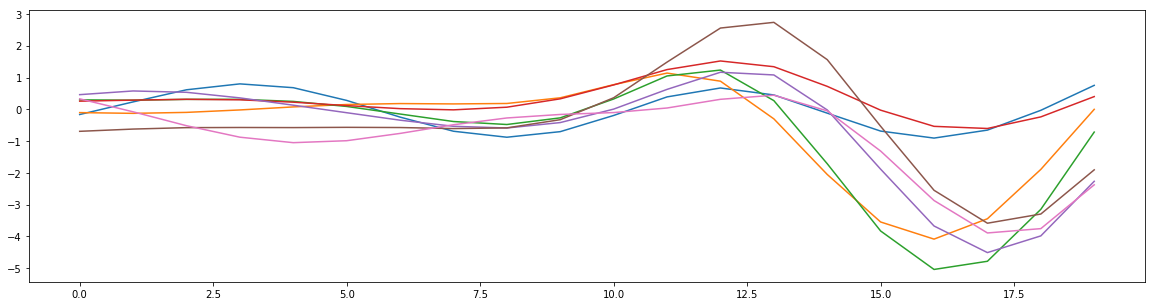

In [665]:
plt.rcParams['figure.figsize'] = (20, 5)
# plt.axvline(1000-14)
plt.plot(rec[5999986-10:5999986+10, [ 1  ,5 , 9 ,12 ,17, 20 ,24]])

In [666]:
def get_waveforms_and_scores_for_template(template_id, flatten=True):
    """
    Return the waveform for a given template
    
    Parameters
    ----------
    flatten: bool
        flatten waveforms along channels
    """
    # get times for spikes whose id correspond the template_id
    spt_k = spt_clean[id_clean == template_id]
        
    # get the number of waveforms used to build that template
    nn = spt_k.shape[0]
    
    # look for those templates
    wf = np.zeros((nn, R, ch_idx.shape[0]))
    for j in range(nn):
        try:
            wf[j] = rec[(spt_k[j]-spike_size):(spt_k[j]+spike_size+1),ch_idx]
        except Exception as e:
            print(spt_k[j], spike_size, ch_idx)
            pass
            
    
    # also get the scores
    score = np.transpose(np.reshape(np.matmul(
        np.reshape(np.transpose(wf,(0,2,1)),(-1, R)),proj),(nn,ch_idx.shape[0],nfeat)),(0,2,1))
    
    if flatten:
        wf = np.reshape(wf, [wf.shape[0], -1])
        score = np.reshape(score, [score.shape[0], -1])
    
    return wf, score

In [667]:
wf, score = get_waveforms_and_scores_for_template(0, flatten=False)
wf.shape, score.shape

((2884, 31, 7), (2884, 3, 7))

In [668]:
wf, score = get_waveforms_and_scores_for_template(0, flatten=True)
wf.shape, score.shape

((2884, 217), (2884, 21))

In [669]:
def get_waveforms_and_scores_for_templates(templates):
    """
    Return waveforms and scores for a group of templates
    along with a vector that indicates the cluster_id for each
    one
    """
    res = [get_waveforms_and_scores_for_template(template_id) for template_id in templates]
    wfs = np.vstack([t[0] for t in res])
    scores = np.vstack([t[1] for t in res])
    labels = np.hstack([np.ones(len(l[0]))*t for l, t in zip(res, templates)])
    return wfs, scores, labels

In [671]:
wfs, score, labels = get_waveforms_and_scores_for_templates(np.unique(id_clean))

5999986 15 [ 1  5  9 12 17 20 24]


In [674]:
wfs.shape, score.shape, labels.shape

((103990, 217), (103990, 21), (103990,))

In [678]:
np.save('wfs', wfs)
np.save('score', score)
np.save('labels', labels)

In [676]:
len(np.unique(labels))

111

In [338]:
def pca_plot(data, colors):
    """
    Reduce dimensionality using PCA
    and plot data
    """
    pca = PCA(n_components=2)

    pca.fit(data)
    reduced = pca.transform(data)
    
    for color in np.unique(colors).astype('int'):
        plt.scatter(reduced[colors == color, 0], reduced[colors == color, 1], label=color, alpha=0.7)

    plt.legend()
    plt.show()
    

(array([  2.,   3.,   9.,  17.,  19.]), array([103,  30, 437, 539, 185]))


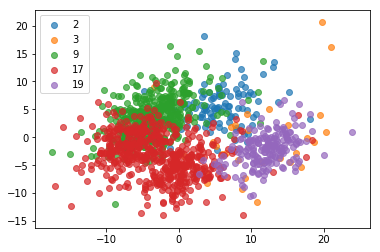

In [339]:
wf, scores, labels = get_waveforms_and_scores_for_templates([ 2,9 ,19, 17 , 3])
print(np.unique(labels, return_counts=True))
pca_plot(scores, labels)

In [543]:
def lda_plot(data, colors, ax=None):
    """
    Reduce dimensionality using LDA
    and plot data
    """
    ax = plt if ax is None else ax

    lda = LDA(n_components=2)
    lda.fit(data, colors)
    reduced = lda.transform(data)

    for color in np.unique(colors).astype('int'):
        ax.scatter(reduced[colors == color, 0], reduced[colors == color, 1],
                    label='Cluster {}'.format(color), alpha=0.7)

    ax.legend()

In [544]:
template_ids = close_templates(templates_in_feature, 3, 3)
print(template_ids)
wf, scores, labels = get_waveforms_and_scores_for_templates(template_ids)

[ 3 26  8]


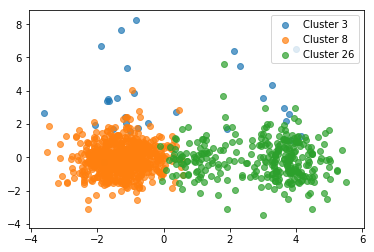

In [545]:
lda_plot(scores, labels)

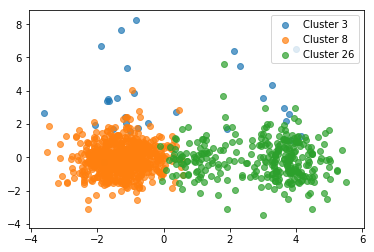

In [546]:
visualize_cluster(3, 2)

In [547]:
def visualize_cluster(cluster_id, k_similar, ax=None):
    """
    Project in 2D a cluster id along with k_similar
    clusters
    """
    template_ids = close_templates(templates_in_feature, cluster_id, k_similar+1)
    wf, scores, labels = get_waveforms_and_scores_for_templates(template_ids)
    lda_plot(scores, labels, ax=ax)

In [548]:
n_clusters = len(np.unique(id_clean))

In [575]:
cluster_ids = np.random.choice(np.unique(id_clean), size=25, replace=False)

In [576]:
cluster_ids

array([ 99,  37,  40,  80,   0,  96,  95,  65,  13,  77, 106,  26,  90,
        58,  33,  35,  86,  44,  51, 104, 108,  12,  48,  43,  18], dtype=int32)

In [586]:
plt.rcParams['figure.figsize'] = (10, 20)

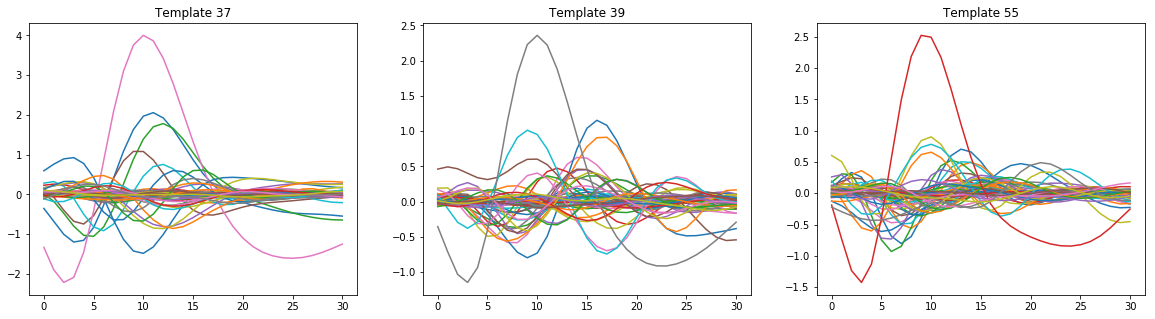

In [606]:
plt.rcParams['figure.figsize'] = (20, 5)
f, axs = plt.subplots(1, 3)

for cluster_id, ax in zip((37, 39, 55), axs):
    ax.plot(mp.templates[:, :, cluster_id].T)
    ax.set_title('Template {}'.format(cluster_id))

plt.legend()
# plt.savefig('wf.pdf')
plt.show()

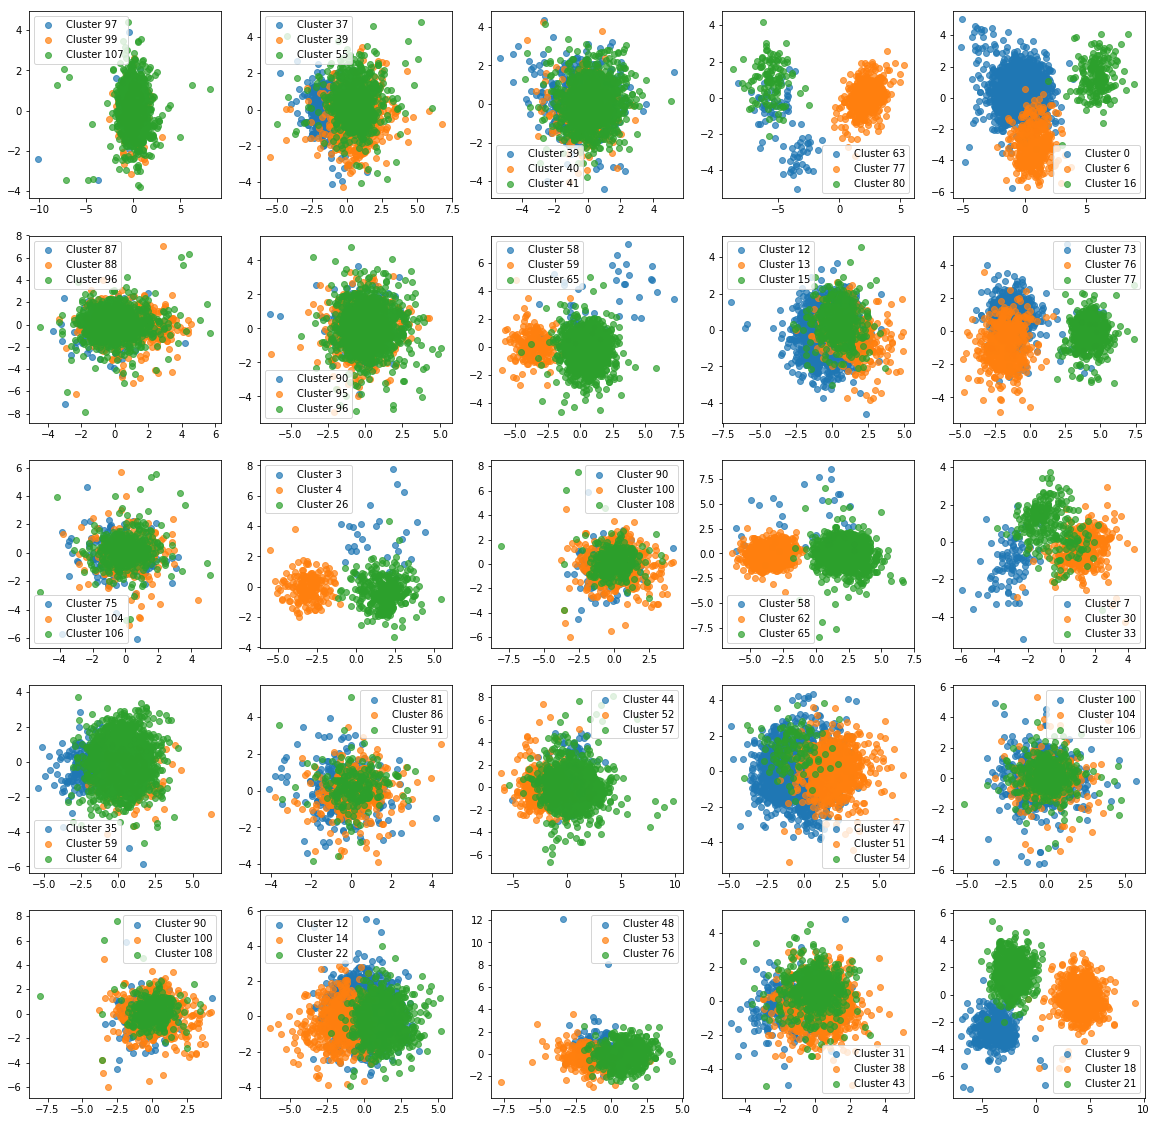

In [610]:
plt.rcParams['figure.figsize'] = (20, 20)
f, axs = plt.subplots(5, 5)
axs = [item for sublist in axs for item in sublist]

for ax, cluster_id in zip(axs, cluster_ids):
    visualize_cluster(cluster_id, k_similar=2, ax=ax)

# plt.savefig('lda.pdf')

In [555]:
def plot_cluster(rec, proj, spt_clean, id_clean, templates, cluster_id, 
                 n_cluster_plot, neighbor, plot_length, plot_width, cols, plot_name1, plot_name2, plot_wf, plot_score):
    
    # get parameters
    R, nfeat = proj.shape
    spike_size = int((R-1)/2)
    nchannel, R, n_templates = templates.shape

    print('templates raw', templates.shape)
    
    # dimension reduction of templates
    templates_in_feature = templates_in_feature_space(templates,proj)
    
    print('templates in ft', templates_in_feature.shape)
        
        
    # choose neighboring templates
    k_idx = close_templates(templates_in_feature, cluster_id, n_cluster_plot)
    
    print('cluster id', cluster_id, 'similar clusters', k_idx)

    # find main channel and neighboring channels
    t_interest = templates[:,:,cluster_id]
    
    print('t interest', t_interest.shape)

    c_main = np.argmax(np.max(t_interest,axis=1))
    ch_idx = np.where(neighbor[c_main])[0]
    
    # get waveforms for all
    wf_all = list()
    score_all = list()
    for k in k_idx:
        # find clear spike times whose cluster_id is the template we are looking for
        # this are the ones that were used to build the template
        spt_k = spt_clean[id_clean == k]
        
        # get the number of waveforms used to build that template
        nn = spt_k.shape[0]
        print('nn', nn)
        
        # look for those templates
        wf = np.zeros((nn, R, ch_idx.shape[0]))
        for j in range(nn):
            wf[j] = rec[(spt_k[j]-spike_size):(spt_k[j]+spike_size+1),ch_idx]

        score = np.transpose(np.reshape(np.matmul(
            np.reshape(np.transpose(wf,(0,2,1)),(-1, R)),proj),(nn,ch_idx.shape[0],nfeat)),(0,2,1))

        wf_all.append(wf)
        score_all.append(score)
    
    max_val = np.max(templates[ch_idx][:,:,k_idx])*3
    min_val = np.min(templates[ch_idx][:,:,k_idx])*3

    # plot waveforms
    if plot_wf:
        count = 1
        time_val = np.arange(R)/20.
        fig = plt.gcf()
        fig.set_size_inches(plot_length, plot_width)
        fig.suptitle("Cluster of interest: " + str(cluster_id)+", main channel: "+str(c_main), fontsize=16)
        for c in range(ch_idx.shape[0]):
            for k in range(k_idx.shape[0]):
                plt.subplot(ch_idx.shape[0],k_idx.shape[0],count)
                plt.plot(time_val,wf_all[k][:,:,c].T)
                plt.plot(time_val,np.mean(wf_all[k][:,:,c], axis=0), linewidth = 5, color='red')
                plt.ylim((min_val,max_val))
                if k == 0:
                    plt.ylabel('channel '+str(ch_idx[c]))
                if c == ch_idx.shape[0]-1:
                    plt.xlabel('time (ms)')
                if c == 0:
                    plt.title('cluster '+str(k_idx[k]))
                count += 1
        plt.savefig(plot_name1)
        plt.show()
    
    
    if plot_score:
        print('templates...', ch_idx)
        print(templates_in_feature[ch_idx][:,:,k_idx].shape)
        tt = np.transpose(templates_in_feature[ch_idx][:,:,k_idx],(2,1,0))
        print(tt.shape)
        tt = np.reshape(tt,[tt.shape[0],-1])
        print(tt.shape)

        pca = PCA(n_components=2)
        pca.fit(tt)
        
#         lda = LDA(n_components=2)
#         lda.fit(tt, range(tt.shape[0]))

        fig = plt.gcf()
        fig.set_size_inches(10, 10)
        for k in range(k_idx.shape[0]):
            print('scores for', k, k_idx[k])
            score_temp = np.reshape(score_all[k],(score_all[k].shape[0],-1))
            print(score_temp.shape)
            score_temp = pca.transform(score_temp)
#             score_temp = lda.transform(score_temp)
            print(score_temp.shape)
            plt.scatter(score_temp[:,0],score_temp[:,1],color=cols[k])

        legend_name = [None]*k_idx.shape[0]
        for k in range(k_idx.shape[0]):
            legend_name[k] = "Cluster "+str(k_idx[k])

        plt.legend(legend_name)
        plt.xlabel('Dimension 0')
        plt.ylabel('Dimension 1')
        plt.savefig(plot_name2)
        plt.show()
        
    
    

templates raw (49, 31, 111)
templates in ft (49, 3, 111)
cluster id 2 similar clusters [ 2  9 19 17  3]
t interest (49, 31)
nn 103
nn 437
nn 185
nn 539
nn 30


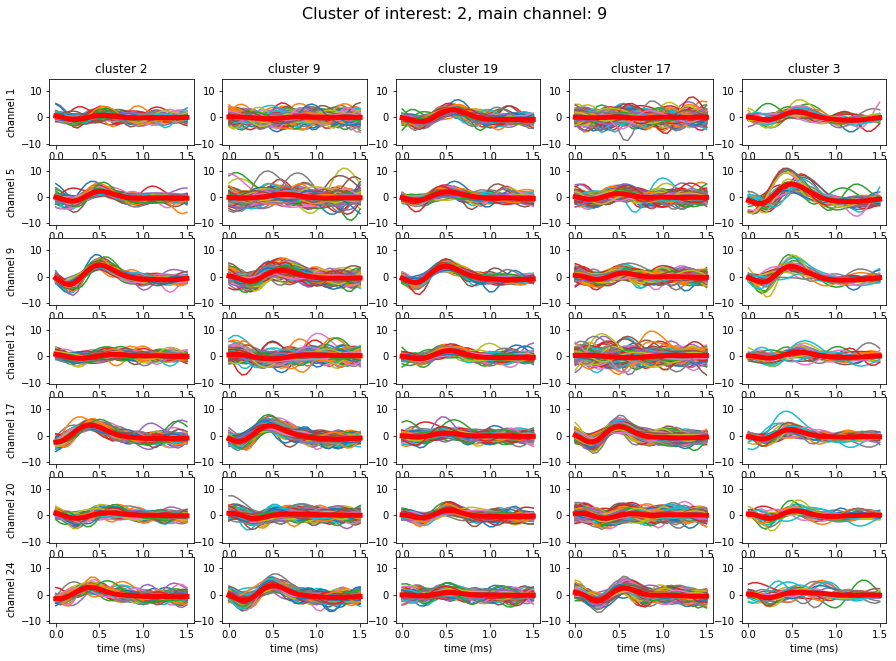

templates... [ 1  5  9 12 17 20 24]
(7, 3, 5)
(5, 3, 7)
(5, 21)
scores for 0 2
(103, 21)
(103, 2)
scores for 1 9
(437, 21)
(437, 2)
scores for 2 19
(185, 21)
(185, 2)
scores for 3 17
(539, 21)
(539, 2)
scores for 4 3
(30, 21)
(30, 2)


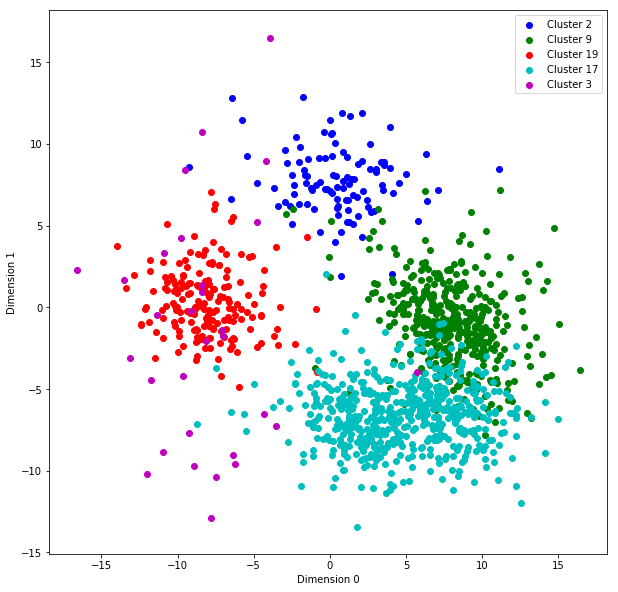

In [418]:
plot_cluster(rec, proj, spt_clean, id_clean, templates, cluster_id, 
             n_cluster_plot, neighbor, plot_length, plot_width, cols, plot_name1, plot_name2, plot_wf, plot_score)